In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from time_series_service import series_to_supervised

In [2]:
# Read and prepare data to linear regression model

df = pd.read_csv('generated/btc_value_em_tweets_sentimental_score.csv')
df.columns = ['DateTime','Compound','Positive', 'Neutral', 'Negative', 'Price']
df = df[['DateTime','Negative','Neutral','Positive','Compound','Price']]
df = df[['DateTime', 'Compound','Price']]
df = df.sort_values('DateTime')
df.set_index('DateTime',inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 361 entries, 2020-07-01 to 2021-06-26
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Compound  361 non-null    float64
 1   Price     360 non-null    float64
dtypes: float64(2)
memory usage: 8.5+ KB


,Compound,Price
DateTime,,
2020-07-01,0.0,144.8
2020-07-02,0.0,18.0
2020-07-03,0.0,-67.3
2020-07-04,0.0,53.4
2020-07-05,0.0,-258.0


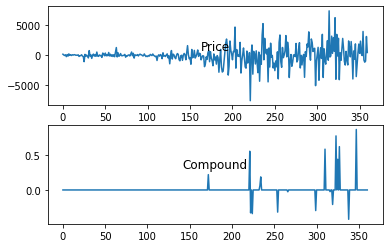

In [3]:
# Plot the time series of all features

columns_groups = [0,1]

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

i = 1
plt.figure()
for column_group in columns_groups:
    plt.subplot(len(columns_groups), 1, i)
    plt.plot(df.values[:, column_group])
    plt.title(df.columns[column_group], y=0.5, loc='center')
    i += 1
plt.show()

In [4]:
# Reframe the data so we can apply supervised learning techniques in a time series

n_days = 1
n_features = 1
n_obs = n_days * n_features

reframed = series_to_supervised(df.values, n_days, 1)
reframed = reframed.drop(reframed.columns[-1:], axis=1)

reframed.head()

,var1(t-1),var2(t-1),var1(t)
1,144.8,0.0,18.0
2,18.0,0.0,-67.3
3,-67.3,0.0,53.4
4,53.4,0.0,-258.0
5,-258.0,0.0,83.0


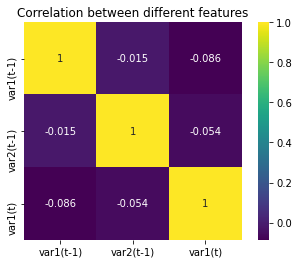

In [5]:
# Plot correlation matrix

correlation = reframed.corr()
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='viridis')
plt.title('Correlation between different features')
plt.show();

In [6]:
# Split train and test data

data = reframed.values

data_df = pd.DataFrame(data=data, columns=['var1(t-1)','var2(t-1)','var1(t)'])

train_size = 0.79
n_train_days = int(len(data_df)*train_size)

df_train, df_test = data_df[0:n_train_days], data_df[n_train_days:]

In [7]:
# Create the varmax model, train it and plot the diagnostics

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_train)

model = VAR(scaled)
model_fit = model.fit()
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Oct, 2021
Time:                     07:32:45
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -82.1452
Nobs:                     282.000    HQIC:                  -82.2380
Log likelihood:           10415.9    FPE:                1.80919e-36
AIC:                     -82.3002    Det(Omega_mle):     1.73434e-36
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error                t-stat            prob
-----------------------------------------------------------------------------
const         0.000000         0.000000                 0.207           0.836
L1.y1         0.000000         0.000000                 2.212           0.027
L1.y2         0.000000         0.000000                 0.329           0.7

In [19]:

predictions = model_fit.forecast(y=scaled, steps=len(data_df))
inv_predictions = scaler.inverse_transform(predictions)

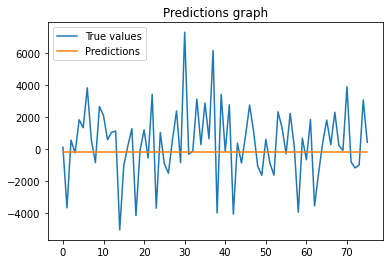

In [20]:
# Plot Results

plt.plot(data_df[n_train_days:]['var1(t)'].values, label="True values")
plt.plot(inv_predictions[n_train_days:, 2], label="Predictions")
plt.title("Predictions graph")
plt.legend(loc="upper left")

plt.show()

In [23]:
# Print the results

mse = mean_squared_error(data_df['var1(t)'].values, inv_predictions[:, 2])
r2 = r2_score(data_df['var1(t)'].values, inv_predictions[:, 2])
rmse = np.sqrt(mse)

print("Coefficient of Determination  (R2):", r2)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Square Error: %.3f" % rmse)

Coefficient of Determination  (R2): -0.006054540232861116
Mean Squared Error (MSE): 2370407.262662336
Root Mean Square Error: 1539.613


In [25]:
# Save the predictions data to csv file

df_sol = pd.DataFrame({'forecast':inv_predictions[:,2],'actual':data_df['var1(t)'].values})
df_sol.to_csv('generated/predictions_sv_var.csv')